# Stable diffusion

O artigo High-Resolution Image Synthesis with Latent Diffusion Models (https://arxiv.org/abs/2112.10752) apresenta a descrição do modelo Stable Diffusion.

### Usando o pipeline do Hugginface

In [1]:
import torch
from diffusers import DiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import PILToTensor
#import diffusers
#diffusers.utils.logging.disable_progress_bar()
device = 'cuda'

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", 
                        torch_dtype=torch.float16, variant="fp16", 
                        use_safetensors=True).to("cuda")

prompt = "A majestic lion jumping from a big stone at night"
generator = torch.Generator(device="cpu").manual_seed(0)
#images = pipeline(prompt, num_inference_steps=50, guidance_scale=6, num_images_per_prompt=4, 
#                  generator=generator).images
#display(*images)

i:\Miniconda3\envs\vc2024\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
i:\Miniconda3\envs\vc2024\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
i:\Miniconda3\envs\vc2024\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Componentes do pipeline

In [2]:
pipeline.config

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')),
            ('text_encoder', ('transformers', 'CLIPTextModel')),
            ('tokenizer', ('transformers', 'CLIPTokenizer')),
            ('unet', ('diffusers', 'UNet2DConditionModel')),
            ('scheduler', ('diffusers', 'PNDMScheduler')),
            ('safety_checker',
             ('stable_diffusion', 'StableDiffusionSafetyChecker')),
            ('feature_extractor', ('transformers', 'CLIPImageProcessor')),
            ('image_encoder', (None, None)),
            ('requires_safety_checker', True),
            ('_name_or_path', 'runwayml/stable-diffusion-v1-5')])

Os componentes que formam o stable diffusion são:

1. vae: Variational Autoencoder. Arquitura muito parecida com a que implementamos no módulo sobre autoencoders. Responsável por extrair atributos da imagem de entrada;
2. text_encoder: Um modelo CLIPTextModel igual ao que implementamos no módulo sobre texto e imagens. Responsável por extrair atributos do texto;
3. tokenizer: tokenizador para o texto;
4. unet: modelo que estima o ruído. Neste caso, o modelo recebe como entrada a imagem com ruído, o nível de ruído (step) e também o texto codificado pelo text_encoder;
5. scheduler: gerador do ruído para o treinamento e também define o passo do processo reverso da difusão no momento da geração de imagens;
6. safety_checker: um mecanismo para evitar imagens ofensivas;
7. feature_extractor: faz a projeção da imagem no mesmo espaço do texto. Implementamos ele na aula sobre texto e imagens. Usado apenas para processar a imagem para o `safety_checker`, que foi treinado de forma separada.



### Latentes do autoencoder

In [4]:
def pil_to_latent(img, vae):

    # pil [0,255] -> tensor [0,1]
    img = PILToTensor()(img)/255
    # Converte os valores do invervalo [0,1] para [-1,1] 
    img = img*2-1
    # Codifica a imagem
    img = img.to(device=vae.device, dtype=vae.dtype)
    with torch.no_grad():
        output = vae.encode(img.unsqueeze(0).to(vae.device)) 
    # Para acessar a saída do codificador:
    latent = output.latent_dist.sample()
    # *Nota: `latent_dist` é uma distribuição Gaussiana, e `sample()` amostra
    # um conjunto de valores dessa distribuição! É possível acessar a média e 
    # desvio padrão da distribuição pelos atributos 
    # output.latent_dist.mean e output.latent_dist.std

    # `scaling_factor` é 1/desvio_padrão dos latentes do modelo autoencoder
    # treinado. Ele é utilizado para normalizar os latentes para eles terem
    # desvio padrão 1 quando forem utilizados como entrada do modelo unet.
    latent = vae.config.scaling_factor*latent

    return latent

def latents_to_pil(latents, vae):

    # Reescala os latentes de volta
    latents = (1/vae.config.scaling_factor)*latents
    with torch.no_grad():
        img = vae.decode(latents).sample
    # [-1,1] -> [0,1]. Trunca os valores menores que zero e maiores que 1
    # que podem aparecer
    img = (img / 2 + 0.5).clamp(0, 1)

    img = img[0].cpu().permute(1, 2, 0).numpy()
    img = (img*255).round().astype("uint8")
    img = Image.fromarray(img)

    return img

input_image = Image.open('../data/basset_hound_53.jpg').resize((512, 512))
encoded = pil_to_latent(input_image, pipeline.vae)
encoded.shape

i:\Miniconda3\envs\vc2024\Lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


torch.Size([1, 4, 64, 64])

O autoencoder codifica a imagem de tamanho 512x512x3 em um espaço reduzido de tamanho 64x64x4. Ou seja, a codificação utiliza 2% da quantidade de valores da imagem original.

Podemos visualizar a imagem codificada:

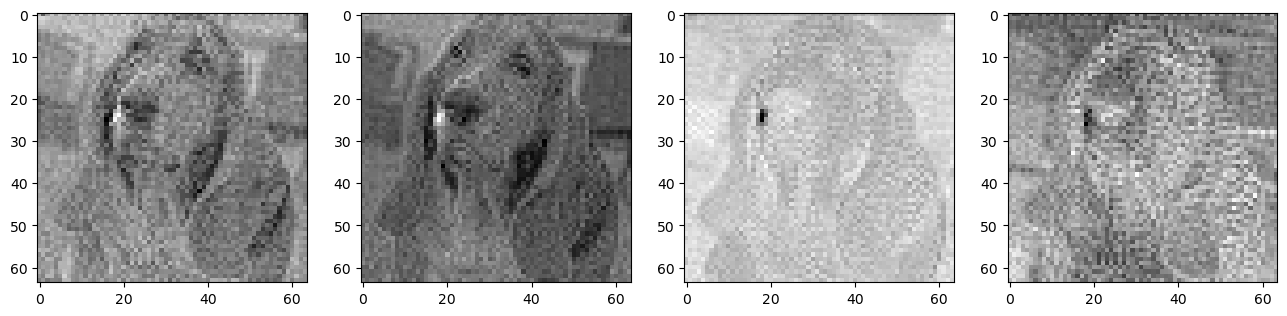

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for idx in range(4):
    axs[idx].imshow(encoded[0][idx].cpu(), cmap='gray')

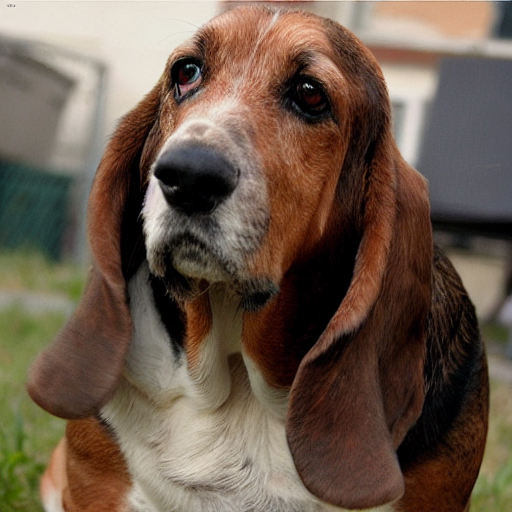

In [6]:
# Decodificação da imagem:
decoded = latents_to_pil(encoded, pipeline.vae)
decoded

Vemos que a imagem recuperada possui alta fidelidade. Portanto, o autoencoder pode ser entendido como um compressor de imagens. Ele foi treinado para representar uma grande quantidade de imagens em um espaço reduzido e conseguir reconstruir elas com sucesso. A aplicação do modelo de difusão nesse espaço reduzido é muito mais rápida do que no espaço original. Essa é a principal contribuição do método Stable Diffusion.

### Passo-a-passo do Stable Diffusion

Iremos realizar passo-a-passo a geração de uma imagem usando o Stable Diffusion

In [7]:
# Componentes do pipeline
vae = pipeline.vae
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder
unet = pipeline.unet
scheduler = pipeline.scheduler

Tokenização

A entrada para a UNet precisa ter um tamanho fixo pre-determinado, por isso usamos `padding="max_length"` e `max_length=max_length`. Isso garante que o texto tokenizado terá o tamanho aceito pela UNet

Também usamos `truncation=True` para garantir que um texto muito grande que ultrapasse o tamanho máximo seja truncado.

In [8]:
max_length = tokenizer.model_max_length
text_input = tokenizer(
    prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt"
)
text_input

{'input_ids': tensor([[49406,   320, 15335,  5567, 11476,   633,   320,  1205,  2441,   536,
           930, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [9]:
text_input = text_input.to(device)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids)[0]
text_embeddings.shape 

torch.Size([1, 77, 768])

Projeção do texto para realizar classifier-free guidance

Criamos um prompt de texto vazio e concatenamos ao texto codificado. O motivo será explicado ao final do notebook

In [10]:
uncond_input = tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
uncond_input = uncond_input.to(device)
uncond_embeddings = text_encoder(uncond_input.input_ids)[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings.shape

torch.Size([2, 77, 768])

#### Geração da imagem

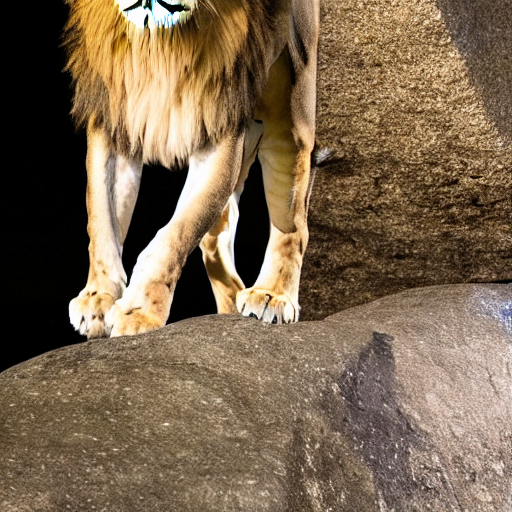

In [70]:
def create_latents(img_height, img_width, vae, generator):
    '''Cria latentes aleatórios.'''

    # Número de blocos do codificador do autoencoder
    num_down_blocks = len(vae.config.block_out_channels)
    # Cada bloco possui um downsample. Usamos isso para encontrar a relação entre
    # o tamanho da imagem de entrada e dos latentes (ex: uma imagem de 512x512
    # é transformada para 64x64 se o stride for 8)
    stride = 2**(num_down_blocks-1)
    channels = vae.config.latent_channels

    # Gera latentes aleatórios com variância 1
    latent_shape = (1, channels, img_height//stride, img_width//stride)
    latents = torch.randn(
        latent_shape,
        generator=generator,
        device=vae.device,
        dtype=vae.dtype
    )
    # Escala inicial da variância dos latentes usada durante o treinamento da unet
    latents = latents*scheduler.init_noise_sigma

    return latents

def generate(latents, text_embeddings, unet, scheduler, n_steps, guidance_scale):
    '''Gera latentes que representam uma imagem codificada.'''

    scheduler.set_timesteps(n_steps)

    for step in scheduler.timesteps:
        # Duplica os latentes para aplicar classifier-free guidance
        latent_model = torch.cat([latents] * 2)

        # Prevê o ruído
        with torch.no_grad():
            noise_pred = unet(latent_model, step, text_embeddings).sample

        # perform guidance
        noise_uncond, noise_text = noise_pred
        noise_pred = noise_uncond + guidance_scale*(noise_text-noise_uncond)

        latents = scheduler.step(noise_pred, step, latents).prev_sample

    return latents

prompt = [prompt]
# tamanho das imagens usadas para treinar o Stable Diffusion. É o melhor tamanho
# para usar ao gerar imagens.
height = 512    
width = 512     
generator = torch.Generator(device=device).manual_seed(0)  

latents_rand = create_latents(height, width, vae, generator)
latents = generate(latents_rand, text_embeddings, unet, scheduler, n_steps=25, guidance_scale=7.5)
image = latents_to_pil(latents, vae)
image

A operação 

`noise_pred = noise_uncond + guidance_scale*(noise_text-noise_uncond)`

realiza a chamada classifier-free guidance. Esta é uma forma de forçar a geração 